# Validation plot, version 0.0

## Experimental notes

In [ ]:
# main points:
    # The intital validation split results in the hold-out 
    # set either over, under, or equally predicting accuracy
        # Solution: loop on validation split

    # The different 

In [ ]:
# Big decision points:

    # Method of pre-training / fine tuning
        # Consistency of these transfer learning methods across cancers
        # Can take a trained encoded, VAE model, or trained decoder
    
    # Method of synthetic sample generation
        # Consistency of these synthetic sample generation methods across cancers
        # See Synthetic sample generation summary
        # driving factor of name for this notebook

    # Removing LGGGBM - initially explored
        # appears to work although requires unique set of compatable experimental requirements
        
    # Dropping all data except GEXP - data files prepped, limited exploration
    
    # Feature selection - initially explored, impact appears limited
    
    # Normalization - explored, show comparison
    
    # VAE Architechture - explored, show comparison
        # Can use a 2D model - demonstrated
        # Can use one-hot encoding for labels
            # Changes sample generation options
            # Use in-built stochasti
    
    # Classical ML model - explored, difference demonstrated
        # No clear pattern identified
    

In [ ]:
# Additional decision points
    # Balancing out the subtype distributions
        # bar plots
    # Method of accuracy
        # F1 vs. raw accuracy

In [ ]:
# Terminology - Pre-train and fine-tune
# Ground in relevace CRFM - Galactaca: zero shot (no fine-tuning)
    # See main take-aways (3) in blog post
# Alphacode also uses this terminology

# Foundation model, direct train-decode

# sample mutation vs. alteration vs. fuzzing vs. noise injection

## Setup

In [ ]:
# Two main operational objectives driving figure development
# 1) Build and quantifiably demonstrate functional model
    # like A B testing, box plots of quality of encoding
    # typically fixed sample sizes
    
# 2) Deploy built model in a sub-sampling framework to create a learning curve
    # Show projection of synthetic data against hold-out set for high-sample count
    # Apply model to undersampled cohort to show improved predictive performance with synthetic genomic data

In [ ]:
# Code file evolution summary

# to i_o/six_0.0
# From i_o/lat_0.0
# data setup dropped in val_1.1, etc series - this where the feature selection is

In [12]:
v = 'six_0.0' # iteration directory name, within i_o

In [ ]:
%whos

## Imports

In [2]:
import seaborn as sns
import pandas as pd
import glob as glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from statistics import stdev
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from matplotlib import rcParams 
from random import sample
from sklearn.metrics import accuracy_score

## Data

### Read files

In [4]:
# The box curve code file series has the feature engineering work

In [3]:
file_paths = sorted(
    glob.glob(
        'i_o/GEXP_MAD_5k_across_no_LGGGBM/*.tsv' # <---- LGGGBM excluded
    ))

### Transfer learning zone

In [ ]:
file_paths

In [ ]:
TCGA_no_BRCA = ['i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 # 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PAAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PCPG_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PRAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/SARC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/SKCM_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/TGCT_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/THCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/THYM_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/UCEC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/UVM_across_5k_no_LGGGBM.tsv']

In [ ]:
tall_stack = pd.DataFrame()
for path in TCGA_no_BRCA:
    print(path)
    file = pd.read_csv(
    path, sep = '\t', index_col = 0)
    tall_stack = pd.concat( [tall_stack, file] ,
                           axis = 0)

In [ ]:
tall_stack.shape

In [ ]:
tall_stack.head(1)

In [ ]:
pre_train_file = tall_stack

In [ ]:
pre_train_file.shape

### Direct VAE train-to-decode and fine-tuning

In [5]:
fine_tune_file = pd.read_csv(
    file_paths[2], sep = '\t', index_col = 0)

In [6]:
fine_tune_file.index.name #

'BRCA'

## Validation split

In [7]:
hold_in_size = 500 # Anchor point for decreasing validation loop
# could there be a summary figure for the experiment that shows the two
# stages - model devel and learning curve

In [76]:
# val_split = 'vs5'
val_split = 'vs6'
hold_in = fine_tune_file.sample(hold_in_size)
hold_out = fine_tune_file.loc[fine_tune_file[~fine_tune_file.index.isin(hold_in.index)].index, :]

In [9]:
hold_in.shape

(500, 5001)

In [10]:
hold_in.Labels.value_counts()

BRCA_1    263
BRCA_2    104
BRCA_3     88
BRCA_4     45
Name: Labels, dtype: int64

In [11]:
hold_out.Labels.value_counts()

BRCA_1    272
BRCA_2    101
BRCA_3     87
BRCA_4     35
Name: Labels, dtype: int64

## Subtype frequency plot

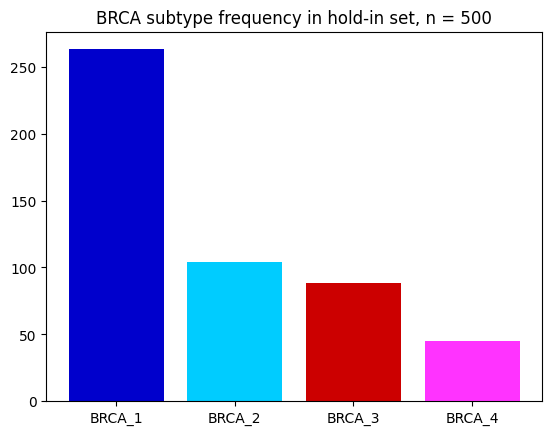

In [13]:
c_list = ['#0000CC','#00CCFF','#CC0000','#FF33FF']
plt.bar(hold_in.Labels.value_counts().index,
        hold_in.Labels.value_counts(),
        color = c_list)
plt.title(hold_in.index.name+' subtype frequency in hold-in set, n = '+str(hold_in_size))
plt.savefig('i_o/'+v+'/subtype_hold-in_n='+str(len(hold_in))+'_frequency.png')

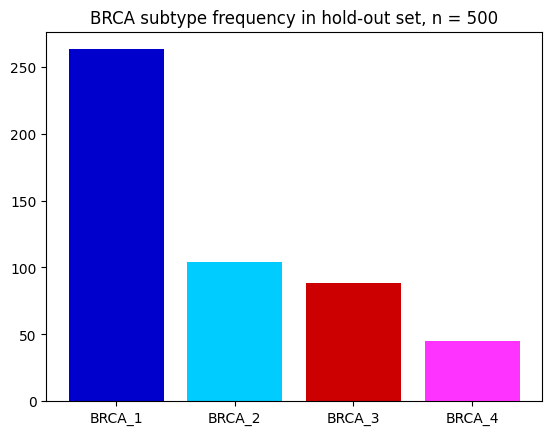

In [14]:
c_list = ['#0000CC','#00CCFF','#CC0000','#FF33FF']
plt.bar(hold_in.Labels.value_counts().index,
        hold_in.Labels.value_counts(),
        color = c_list)
plt.title(hold_in.index.name+' subtype frequency in hold-out set, n = '+str(hold_in_size))
plt.savefig('i_o/'+v+'/subtype_hold-out_n='+str(len(hold_out))+'_frequency.png')

In [15]:
val_split

'vsX'

## Input validation plot

In [18]:
repeats = 50 # set for all running average and summary plots

In [77]:
print('Start input validation with RF')
hld_in_inpt_raw_acc_lst = []
hld_out_inpt_raw_acc_lst = []
hld_in_inpt_running_average = []
hld_out_inpt_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 10:
        print('Ten cross-folds complete')
    X_hold_in = hold_in.iloc[:, 1:]
    y_hold_in = hold_in.iloc[:, 0]
    
    X_hold_out = hold_out.iloc[:, 1:]
    y_hold_out = hold_out.iloc[:, 0]    
    
    clf_hld_in = RandomForestClassifier()
    clf_hld_out = RandomForestClassifier()
    
    clf_hld_in.fit(X_hold_in, y_hold_in)
    clf_hld_out.fit(X_hold_out, y_hold_out) # This is a no-no on the VAE
    
    hld_in_raw_acc = accuracy_score(y_hold_out, clf_hld_in.predict(X_hold_out))
    hld_out_raw_acc = accuracy_score(y_hold_in, clf_hld_out.predict(X_hold_in))

    hld_in_inpt_raw_acc_lst.append(hld_in_raw_acc) # Box plots
    hld_out_inpt_raw_acc_lst.append(hld_out_raw_acc)
    
    hld_in_inpt_running_average.append(mean(hld_in_inpt_raw_acc_lst))
    hld_out_inpt_running_average.append(mean(hld_out_inpt_raw_acc_lst))

print('Input transfer predictions complete')

Start input validation with RF
Ten cross-folds complete
Input transfer predictions complete


In [21]:
v

'six_0.0'

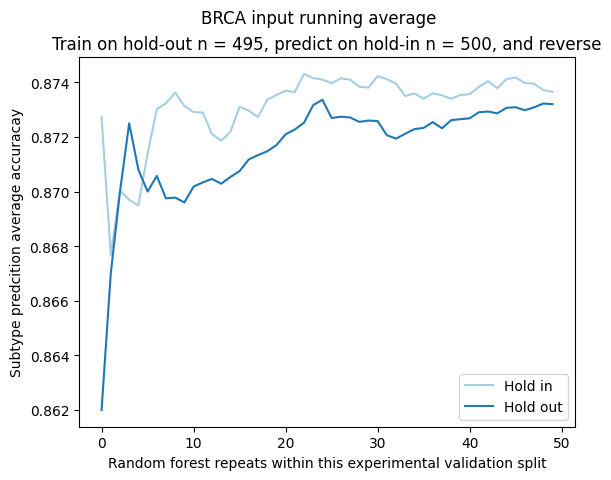

In [78]:
plt.plot(hld_in_inpt_running_average, color = plt.cm.Paired(0), label = 'Hold in')
plt.plot(hld_out_inpt_running_average, color = plt.cm.Paired(1), label = 'Hold out')
plt.suptitle(hold_in.index.name + ' input running average')
plt.title('Train on hold-out n = '+str(
    len(hold_out))+', predict on hold-in n = '+str(
    len(hold_in))+', and reverse')
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/input_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

In [ ]:
# signal discrepency between hold-in and hold-out sets is confounding VAE

In [ ]:
# Train / test split on sub-sections of each file for validation

In [ ]:
# could put some box stars here

In [ ]:
hld_in_inpt_raw_acc_lst

In [42]:
pip install statannot

Note: you may need to restart the kernel to use updated packages.


In [43]:
from statannot import add_stat_annotation

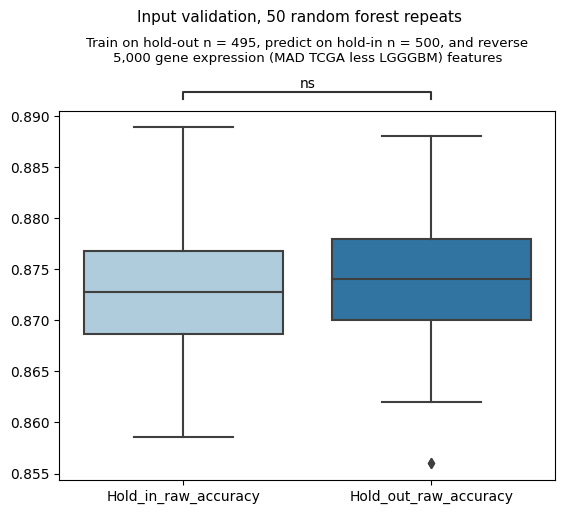

In [79]:
input_val_frame = pd.DataFrame({'Hold_in_raw_accuracy':hld_in_inpt_raw_acc_lst,
                              'Hold_out_raw_accuracy':hld_out_inpt_raw_acc_lst})

ax = sns.boxplot(input_val_frame, palette = [plt.cm.Paired(0), plt.cm.Paired(1)])
plt.suptitle('Input validation, '+str(repeats)+' random forest repeats',
             fontsize = 11, y = 1.09)
plt.title('Train on hold-out n = '+str(
    len(hold_out))+', predict on hold-in n = '+str(
    len(hold_in))+', and reverse\n5,000 gene expression (MAD TCGA less LGGGBM) features',
          fontsize = 9.5, y = 1.11)

add_stat_annotation(ax,
                    data=input_val_frame,
                    # x=x, y=y, order=order,
                    box_pairs=[('Hold_in_raw_accuracy', 'Hold_out_raw_accuracy')],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.savefig(
    'i_o/'+v+'/input_val_'+str(hold_in_size)+'_'+val_split+'.png', bbox_inches = 'tight')

## VAE Setup

In [75]:
# Function set for leave one out loop
def compute_latent(x): # x: This function is argument one in the Lambda layer
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

# Set custom layer , will need all this at start of shell script
class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

## VAE training

In [80]:
itr = 'six_0.0'

2022-12-20 13:52:57.608024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:52:57.648085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:52:57.681806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:52:57.838170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:52:57.886445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:52:57.913077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:52:58.347724: I tensorflow/core/grappler/optimizers/cust

Train and decode with mad_5k_acros_no_LGGGBM feature set experiment done


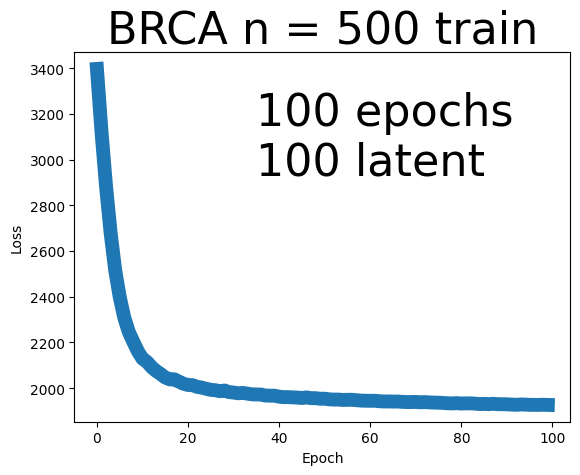

In [83]:
# Train and direct decode

train_file = hold_in   # <---- *** Do not train the VAE ever on hold-out
fit_on_plot_title = hold_in.index.name + ' n = ' + str(len(hold_in))
fit_on_file_write = hold_in.index.name + '_n_'+ str(len(hold_in))

pre_trn = 'NONE'
feature_set = 'mad_5k_acros_no_LGGGBM'

pre_train_epochs = 'NA'
fine_tune_epochs = 'NA'

features = train_file.columns[1:]

original_dim = len(features)
feature_dim = len(features)
latent_dim = 100

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005
kappa = 1

beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

train_epochs = 100

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],
            epochs=train_epochs,
                  batch_size=50,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=0
                  )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )

plt.savefig(
    'i_o/'+itr+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+
    feature_set+
    '.png', bbox_inches='tight')

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_file.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_file.iloc[:, 1:])),
                       index = train_file.index, columns = train_file.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_file.iloc[:, 1:]),
             index=train_file.index,
        )
latent_object.index.name = hold_in.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+itr+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_latent_object_latent_dim.'+str(latent_dim)+
    '_'+feature_set+
    '.tsv',
    sep = '\t')

decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+itr+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+
    '.tsv',
    sep = '\t')

print('Train and decode with '+feature_set+' feature set experiment done')

## VAE pre-training, and fine-tuning

### Pre-training

2022-12-15 09:53:04.217333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:53:04.258261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:53:04.289066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:53:04.491254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:53:04.536834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:53:04.562611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:53:06.919257: I tensorflow/core/grappler/optimizers/cust

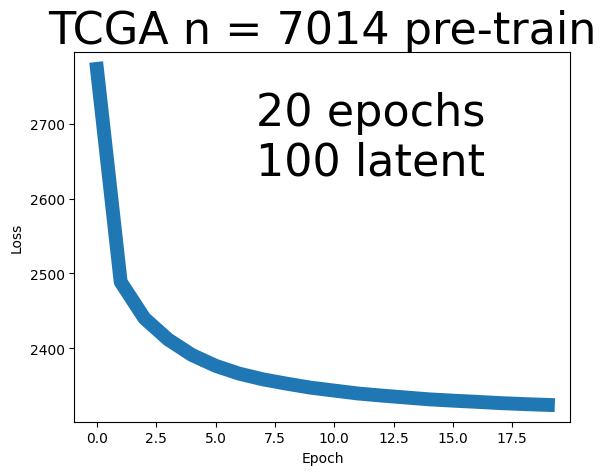

In [210]:
# Pre-train fitting with MAD 5k taken

train_file = pre_train_file
fit_on_plot_title = 'TCGA n = ' + str(len(pre_train_file))
fit_on_file_write = 'TCGA_n_'+ str(len(pre_train_file))
pre_trn = 'NONE'
feature_set = 'mad_5k_across'

fine_tune_epochs = 'NA'

features = train_file.columns[1:] # Now with pre-fit and fine-tune setup toggles

original_dim = len(features)
feature_dim = len(features)
latent_dim = 100               # Toggle here; to plot labels <--- Latent feature set diminsionality       *******

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005
kappa = 1

beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta]) # Take-off point from pre-training to fine-tuning

pre_train_epochs = 20

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],  #  fit the VAE on object, toggled in the setup
            epochs=pre_train_epochs, batch_size=50, shuffle=True,
            callbacks=[WarmUpCallback(beta, kappa)],
                 verbose=0 #  <---------------------- turn this on for production *************
                 )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' pre-train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(pre_train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )

# plt.legend(loc="lower left")
plt.savefig(
    'i_o/'+itr+'/fit.'+fit_on_file_write+'.epochs.'+str(pre_train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+ # Do not change latent dim in the middle of transfer training
    # '_pltv-'+str(plt_v)+
    # 'fitting_epochs.'+str(epochs)+'_'+
    feature_set+'_'+itr+
    '.png', bbox_inches='tight')

In [211]:
itr

'val_0'

### Fine-tuning

/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-12-15 09:54:21.804022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 09:54:21.886053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fine tuning with mad_5k_across feature set experiment done


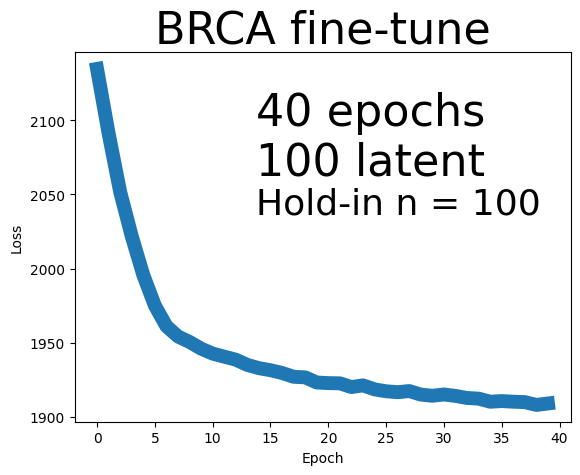

In [212]:
# Fine-tuning
# pretrain epochs variable in memory from above, latent dim also set already at this point

train_file = hold_in
pre_trn = fit_on_file_write
fit_on = hold_in.index.name

fine_tune_epochs = 40 # Overwrite 'NA' for this variable, from above; fine-tuning easy: 100, hard: 200

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],  #  fit the VAE on object, toggled in the setup
            epochs = fine_tune_epochs, batch_size=50, shuffle=True,
            callbacks = [WarmUpCallback(beta, kappa)],
                 verbose=0 #  <---------------------- turn this on for production *************
                 )

fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on+' fine-tune', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(fine_tune_epochs)+' epochs'+
            '\n'+str(latent_dim)+' latent',       
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )
plt.annotate('Hold-in n = '+str(hold_in.shape[0]),             
            xy = (.4, .6), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )

# plt.legend(loc="lower left")
plt.savefig(
    'i_o/'+itr+'/fit.'+fit_on+'.epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_latent_dim.'+str(latent_dim)+'_'+ # Do not change latent dim in the middle of transfer training
    # '_pltv-'+str(plt_v)+
    # 'fitting_epochs.'+str(epochs)+'_'+
    feature_set+'_'+itr+
    '.png', bbox_inches='tight') # version 18, norm within cohort
# plt.close()

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_file.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_file.iloc[:, 1:])),
                       index = train_file.index, columns = train_file.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_file.iloc[:, 1:]),
             index=train_file.index,
                # columns=decode_df.iloc[:, 1:].columns # Columns are different because this is latent space
        )
latent_object.index.name = hold_in.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+itr+'/fit.'+fit_on+'.epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_latent_object_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+itr+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+itr+'/fit.'+fit_on+'.epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+itr+
    '.tsv',
    sep = '\t')

print('Fine tuning with '+feature_set+' feature set experiment done')

## Inline notes

In [ ]:
# Input blue
# Latent red
# Decoded green
# Orange

In [ ]:
# convert column labels for i_o - done
# run two consective runs
    # overlay lines
# switch to trn / val notation on plots

## Latent plus input validation plot

In [ ]:
# Get the encoder
    # Because a hold-out set must have same feature space to run a test on
    # This means a train-set trained encoder is required

In [ ]:
# The encoder in memory was trained on the hold-in set

In [84]:
hold_out_encoded = pd.DataFrame(encoder.predict( # its ok the sample count does not match here, this is the whole point
    hold_out.iloc[:, 1:]),
        index = hold_out.index)
hold_out_encoded_labeled = pd.concat(
    [pd.DataFrame(hold_out.Labels),
     hold_out_encoded] , axis =1)

In [85]:
lat_pths = sorted(glob.glob('i_o/six_0.0/fit.BRCA*latent_object*.tsv')) # what is this?
for pth in lat_pths:
    print(pth)

i_o/six_0.0/fit.BRCA_n_500.epochs.100_pre_trained_on.NONE.epochs.NA_latent_object_latent_dim.100_mad_5k_acros_no_LGGGBM.tsv


In [ ]:
# Only the hold-in gets shown to the VAE for training

In [87]:
hold_in_lat = pd.read_csv(lat_pths[0], sep = '\t', index_col = 0)

In [107]:
hold_out_encoded_labeled.columns = hold_in_lat.columns

In [96]:
repeats = 10

In [109]:
# Latent vs. input, hold-in and hold-out

print('Start input transfer')
hld_in_lat_raw_acc_lst = [] # to summary box
hld_out_lat_raw_acc_lst = []
hld_in_lat_running_average = [] # to running average plot
hld_out_lat_running_average = []

for r in list(range(0, repeats)):
    if r == 10:
        print('Ten cross-folds complete')
    X_hold_in = hold_in_lat.iloc[:, 1:]
    y_hold_in = hold_in_lat.iloc[:, 0]
    
    X_hold_out = hold_out_encoded_labeled.iloc[:, 1:]
    y_hold_out = hold_out_encoded_labeled.iloc[:, 0]    
    
    clf_hld_in = RandomForestClassifier()
    clf_hld_out = RandomForestClassifier()
    
    clf_hld_in.fit(X_hold_in, y_hold_in)
    clf_hld_out.fit(X_hold_out, y_hold_out)

    hld_in_lat_raw_acc = accuracy_score(y_hold_out, clf_hld_in.predict(X_hold_out)) #
    hld_out_lat_raw_acc = accuracy_score(y_hold_in, clf_hld_out.predict(X_hold_in))

    hld_in_lat_raw_acc_lst.append(hld_in_lat_raw_acc) # Box plots
    hld_out_lat_raw_acc_lst.append(hld_out_lat_raw_acc)
    
    hld_in_lat_running_average.append(mean(hld_in_lat_raw_acc_lst)) # 
    hld_out_lat_running_average.append(mean(hld_out_lat_raw_acc_lst))

print('Input transfer predictions complete')

Start input transfer
Input transfer predictions complete


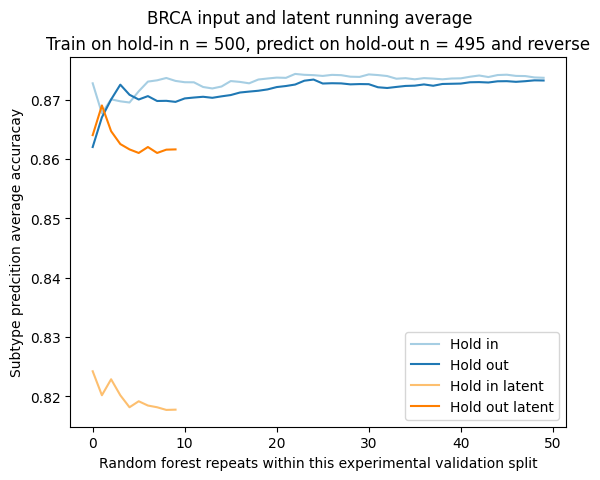

In [110]:
plt.plot(hld_in_inpt_running_average, color = plt.cm.Paired(0), label = 'Hold in')
plt.plot(hld_out_inpt_running_average, color = plt.cm.Paired(1), label = 'Hold out')
plt.plot(hld_in_lat_running_average, color = plt.cm.Paired(6), label = 'Hold in latent')
plt.plot(hld_out_lat_running_average, color = plt.cm.Paired(7), label = 'Hold out latent')
plt.suptitle(hold_in.index.name + ' input and latent running average')
plt.title('Train on hold-in n = '+str(
    len(hold_in))+', predict on hold-out n = '+str(
    len(hold_out))+' and reverse')
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/input_latent_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

## Decoded plus latent and input validation plot

In [111]:
dec_pths = sorted(glob.glob('i_o/six_0.0/fit.BRCA*decoded*.tsv'))
for pth in dec_pths:
    print(pth)

i_o/six_0.0/fit.BRCA_n_500.epochs.100_pre_trained_on.NONE.epochs.NA_decoded_obj_latent_dim.100_mad_5k_acros_no_LGGGBM.tsv


In [112]:
len(hold_in)

500

In [114]:
hold_in_dec = pd.read_csv(dec_pths[0], sep = '\t', index_col = 0)

In [115]:
hold_out

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AALI,BRCA_4,0.000056,0.030875,0.101237,0.091098,0.001082,0.000731,0.000005,0.038961,0.028947,...,0.218348,0.148038,0.242784,0.267978,0.104376,0.202719,0.138612,0.143707,0.338390,0.067471
TCGA-3C-AALJ,BRCA_2,0.000010,0.026908,0.102118,0.102970,0.000007,0.000006,0.000000,0.019658,0.002073,...,0.170624,0.215088,0.274446,0.128449,0.098466,0.112884,0.128195,0.210542,0.172334,0.069492
TCGA-5T-A9QA,BRCA_2,0.001716,0.004724,0.003911,0.005710,0.000007,0.000006,0.000000,0.000043,0.000517,...,0.196252,0.121254,0.221651,0.338770,0.107810,0.217896,0.360953,0.167946,0.158608,0.019774
TCGA-A1-A0SD,BRCA_1,0.001583,0.011526,0.058632,0.110933,0.017380,0.009887,0.000294,0.016601,0.006959,...,0.205047,0.282356,0.230142,0.206673,0.221482,0.232778,0.081647,0.081541,0.144378,0.062085
TCGA-A1-A0SE,BRCA_1,0.000031,0.004247,0.124589,0.084556,0.016569,0.008110,0.000008,0.018951,0.004834,...,0.207173,0.289184,0.218281,0.188423,0.216273,0.214267,0.100746,0.154152,0.213483,0.106551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44,BRCA_1,0.000270,0.008408,0.151985,0.066331,0.002340,0.002423,0.000003,0.009339,0.001252,...,0.323407,0.133397,0.204383,0.218225,0.092523,0.313693,0.085056,0.161550,0.245442,0.077549
TCGA-XX-A899,BRCA_1,0.000014,0.007113,0.115542,0.087292,0.003768,0.002692,0.000110,0.008042,0.008191,...,0.096283,0.344518,0.211751,0.236458,0.174349,0.185939,0.144916,0.119365,0.122980,0.171991
TCGA-XX-A89A,BRCA_1,0.003056,0.004876,0.254498,0.150192,0.003515,0.003370,0.000086,0.080189,0.012612,...,0.097096,0.213312,0.294989,0.173609,0.149934,0.185313,0.229788,0.164834,0.184412,0.240940


In [116]:
# Take trained encoder and decoder
val_decoded = pd.DataFrame(decoder.predict(encoder.predict(hold_out.iloc[:, 1:])),
                       index = hold_out.index, columns = hold_out.iloc[:, 1:].columns)

In [119]:
trn = hold_in

In [121]:
hold_in.shape

(500, 5001)

In [120]:
trn.shape

(500, 5001)

In [118]:
decoded.shape

(500, 5000)

In [122]:
trn_decoded = decoded

In [79]:
# Training and validation: input, latent, decoded

print('Start input transfer')

val_decoded_raw_acc_lst = []
val_decoded_running_average = []

for r in list(range(0, repeats)):
    if r == 10:
        print('Ten cross-folds complete')
    X_hold_in = hold_in_dec.iloc[:, 1:]
    y_hold_in = hold_in_dec.iloc[:, 0]
    
    X_hold_out = hold_out_dec.iloc[:, 1:]
    y_hold_out = hold_out_dec.iloc[:, 0]    
    
    clf_hld_in = RandomForestClassifier()
    clf_hld_out = RandomForestClassifier()
    
    clf_hld_in.fit(X_hold_in, y_hold_in)
    clf_hld_out.fit(X_hold_out, y_hold_out)
    
    hld_in_dec_raw_acc = accuracy_score(y_hold_out, clf_hld_in.predict(X_hold_out))
    hld_out_dec_raw_acc = accuracy_score(y_hold_in, clf_hld_out.predict(X_hold_in))

    hld_in_dec_raw_acc_lst.append(hld_in_dec_raw_acc) # Box plots
    hld_out_dec_raw_acc_lst.append(hld_out_dec_raw_acc)
    
    hld_in_dec_running_average.append(mean(hld_in_dec_raw_acc_lst))
    hld_out_dec_running_average.append(mean(hld_out_dec_raw_acc_lst))

print('Input transfer predictions complete')

Start input transfer
Input transfer predictions complete


In [80]:
v

'six_0.0'

In [81]:
val_split = 'vsX'

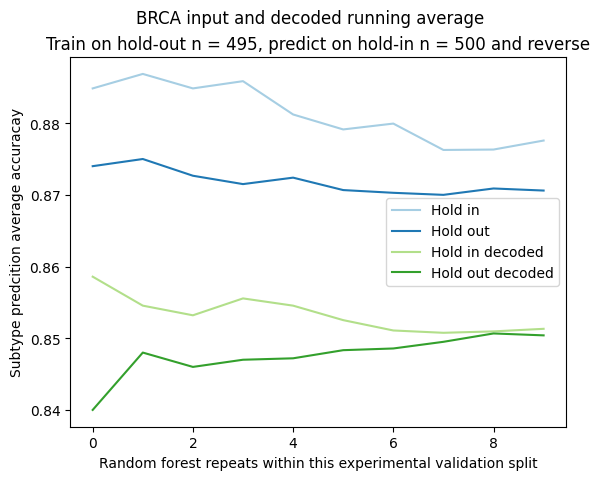

In [82]:
plt.plot(hld_in_inpt_running_average, color = plt.cm.Paired(0), label = 'Hold in')
plt.plot(hld_out_inpt_running_average, color = plt.cm.Paired(1), label = 'Hold out')
plt.plot(hld_in_dec_running_average, color = plt.cm.Paired(2), label = 'Hold in decoded')
plt.plot(hld_out_dec_running_average, color = plt.cm.Paired(3), label = 'Hold out decoded')
plt.suptitle(hold_in.index.name + ' input and decoded running average')
plt.title('Train on hold-out n = '+str(
    len(hold_out))+', predict on hold-in n = '+str(
    len(hold_in))+' and reverse')
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/input_decoded_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

In [30]:
latent_obj = pd.read_csv(
    'i_o/lat_0.0/fit.BRCA_n_500.epochs.100_pre_trained_on.NONE.epochs.NA_latent_object_latent_dim.100_mad_5k_acros_no_LGGGBM_lat_0.0.tsv',
    sep = '\t', index_col = 0)

In [31]:
print('Start latent transfer')
raw_acc_lst = []
running_average_F1 = []
lat_running_average_acrcy = []
for r in list(range(0, repeats)):
    if r == 10:
        print('Ten cross-folds complete')
    X_lat = latent_obj.iloc[:, 1:]
    y_lat = latent_obj.iloc[:, 0]
    
    clf = RandomForestClassifier()
    clf.fit(X_lat, y_lat)

    X_hold_out = hold_out.iloc[:, 1:]
    y_hold_out = hold_out.iloc[:, 0]
    
    raw_acc = accuracy_score(y_hold_out, clf.predict(X_hold_out))

    raw_acc_lst.append(raw_acc)
    
    lat_running_average_acrcy.append(mean(raw_acc_lst))

print('Latent transfer predictions complete')


plt.plot(inpt_running_average_acrcy, color = plt.cm.Paired(1), label = 'Raw accuracy')
plt.plot(lat_running_average_acrcy, color = plt.cm.Paired(3), label = 'Raw accuracy')

plt.title('Input vs. latent running average, train on on '+str(len(hold_in))+' samples,'+
          ' test on '+str(len(hold_out))+' hold-out samples')
plt.ylabel('Subtype predcition accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/lat_0.0/input_vs_latent_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

Start latent transfer


/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- N:GEXP::?:653553:
- N:GEXP::A1BG:1:
- N:GEXP::A2M:2:
- N:GEXP::A2ML1:144568:
- N:GEXP::A4GALT:53947:
- ...
Feature names seen at fit time, yet now missing:
- 0
- 1
- 10
- 11
- 12
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 5000 features, but RandomForestClassifier is expecting 100 features as input.

In [ ]:
# Encode the hold-out set (?)

# Synth main

In [82]:
synth_ndx_strt = 0
up_or_down = [1, -1]

# synth_full_frame05 = pd.DataFrame()
# synth_full_frame10 = pd.DataFrame()
synth_full_frame = pd.DataFrame()

for subtype in sorted(latent_obj.Labels.unique()): # Subset the latent feature frame on each subtype
    
    print(subtype)
    
    sub = latent_obj[latent_obj.Labels == subtype]
    synth_lat_feat_vec = []
    
    sub_len = len(sub)
    synth_sub_len = len(sub)*1  # <------ Toggle the integer at the end of this line to amplify the sample size
    
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])

    for lat_feat in sub.columns[1:]:               # Go through the subtype latent feature set,
        lat_col = sub.loc[:, lat_feat]

        rand_lat_feat_vals = lat_col.sample(
            synth_sub_len, replace = True)
        new_vals = []
        for val in rand_lat_feat_vals:
            new_vals.append(val+rand_lat_feat_vals.mean()*.05*sample(up_or_down,1)[0]) # Fuzz
        fuzzed = pd.Series(new_vals, index = synth_index)
        synth_sub_frame = pd.concat(
            [synth_sub_frame, fuzzed], axis = 1)
        
    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0)
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len

BRCA_1
BRCA_2
BRCA_3
BRCA_4


In [83]:
synth_full_frame

,Labels,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SYNTH-BRCA-00000,BRCA_1,1.378694,-0.035238,0.462018,0.583511,0.760827,-0.027015,1.792131,1.919778,-0.008564,...,-0.025719,0.881767,0.899886,1.101831,-0.036013,1.414343,-0.016467,0.743627,-0.034175,1.218872
SYNTH-BRCA-00001,BRCA_1,-0.035481,-0.035238,-0.014214,1.015628,-0.031850,0.597754,1.718227,2.855293,-0.008564,...,-0.025719,0.949389,-0.012774,-0.028704,0.036013,0.822176,0.016467,1.044737,0.034175,0.019967
SYNTH-BRCA-00002,BRCA_1,1.247989,1.530917,-0.014214,1.024267,-0.031850,-0.027015,1.728134,0.488852,0.008564,...,0.025719,1.108579,0.012774,1.328086,0.241831,1.415644,0.016467,1.298699,0.911135,0.019967
SYNTH-BRCA-00003,BRCA_1,1.406535,1.385403,-0.014214,0.280000,1.103154,0.027015,1.501515,0.486664,0.008564,...,0.936514,0.757107,0.012774,0.588932,0.638733,1.707318,1.126274,1.265947,0.730739,1.218872
SYNTH-BRCA-00004,BRCA_1,1.247989,1.461578,-0.014214,0.301262,-0.031850,-0.027015,0.031998,1.242706,0.893304,...,1.437528,0.048166,0.267872,1.001050,0.775775,0.898261,1.039690,0.034596,0.792037,0.973175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SYNTH-BRCA-00195,BRCA_4,1.208568,1.276371,-0.018512,-0.002608,1.969396,0.910561,0.027768,-0.024962,1.511063,...,0.707861,0.008094,-0.003341,1.509982,-0.076422,1.870307,0.007315,1.437112,-0.002229,-0.011989
SYNTH-BRCA-00196,BRCA_4,-0.049172,0.036007,0.018512,0.002608,-0.035470,0.286859,2.205459,-0.024962,1.489686,...,-0.033222,0.008094,0.003341,1.202102,0.076646,1.890648,0.007315,0.031781,0.002229,0.011989
SYNTH-BRCA-00197,BRCA_4,2.862118,1.178519,-0.018512,0.002608,1.389763,1.896215,-0.027768,2.341040,1.244137,...,0.033222,-0.008094,-0.003341,-0.031579,2.427851,1.569772,0.007315,1.809031,-0.002229,-0.011989
SYNTH-BRCA-00198,BRCA_4,-0.049172,1.261162,0.917414,0.002608,-0.035470,0.910561,1.267234,0.024962,0.070020,...,1.411994,1.328470,-0.003341,1.450593,2.935570,1.977205,0.985940,1.074874,-0.002229,-0.011989


# Devel

In [ ]:
input_transfer_frame = pd.DataFrame({'F1_score':F1_scr_lst,
                                    'Raw_accuracy':raw_acc_lst})

ax = sns.boxplot(input_transfer_frame, palette = [plt.cm.Paired(2), plt.cm.Paired(3)])
plt.suptitle('Decoded validation, '+str(repeats)+' random forest repeats', fontsize = 11)
plt.title('Train a random forest on '+str(hold_in_size)+' BRCA samples using 5,000 gene expression (MAD TCGA less LGGGBM) features then predict on '+str(len(hold_out+' hold-out samples',
          fontsize = 10)
plt.savefig(
    'i_o/val_0/dec_val_'+run+'.png', bbox_inches = 'tight')

In [23]:
dec_pths = sorted(glob.glob('i_o/bx_crv4/fit.BRCA*decoded*.tsv'))

In [194]:
dec = pd.read_csv(pth, sep = '\t', index_col = 0)

In [47]:
pth.split('_')[2].split('.')[3]

'80'

In [28]:
full_stack = pd.concat(
    [hld_out_frame, hld_in_frame, fig_stack], axis = 0)

##### Color section

In [108]:
sns.color_palette("hls", 10)[2]

(0.7247999999999999, 0.86, 0.33999999999999997)

In [109]:
pal = sns.color_palette()

In [112]:
print(pal)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


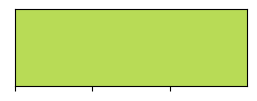

In [113]:
sns.palplot(sns.color_palette("hls", 10)[2])

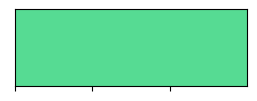

In [114]:
sns.palplot(sns.color_palette("hls", 10)[4])

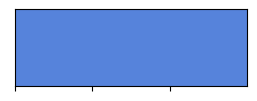

In [115]:
sns.palplot(sns.color_palette("hls", 10)[6])

In [124]:
sns.color_palette("hls", 10)[6]

(0.33999999999999997, 0.5167999999999995, 0.86)

In [163]:
sns.color_palette("hls", 10)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6207999999999999)]

In [155]:
sns.color_palette("hls", 10)[0]

(0.86, 0.3712, 0.33999999999999997)

In [57]:
full_stack

,train_config,F1s
0,hold-out,0.780673
1,hold-out,0.828093
2,hold-out,0.855923
3,hold-out,0.820381
4,hold-out,0.875573
...,...,...
55,15_80,0.875777
56,15_80,0.906809
57,15_80,0.803039
58,15_80,0.852380


In [153]:
full_stack.train_config.unique()

array(['hold-out', 'hold-in', '12_70', '15_70', '12_80', '15_80'],
      dtype=object)

In [30]:
tune_stack.train_config.unique()

array(['hold-out', 'hold-in', '10_40', '20_40', '10_60', '20_60', 'blend'],
      dtype=object)

In [29]:
tune_stack = pd.concat( [full_stack, blend_stack] , axis = 0)

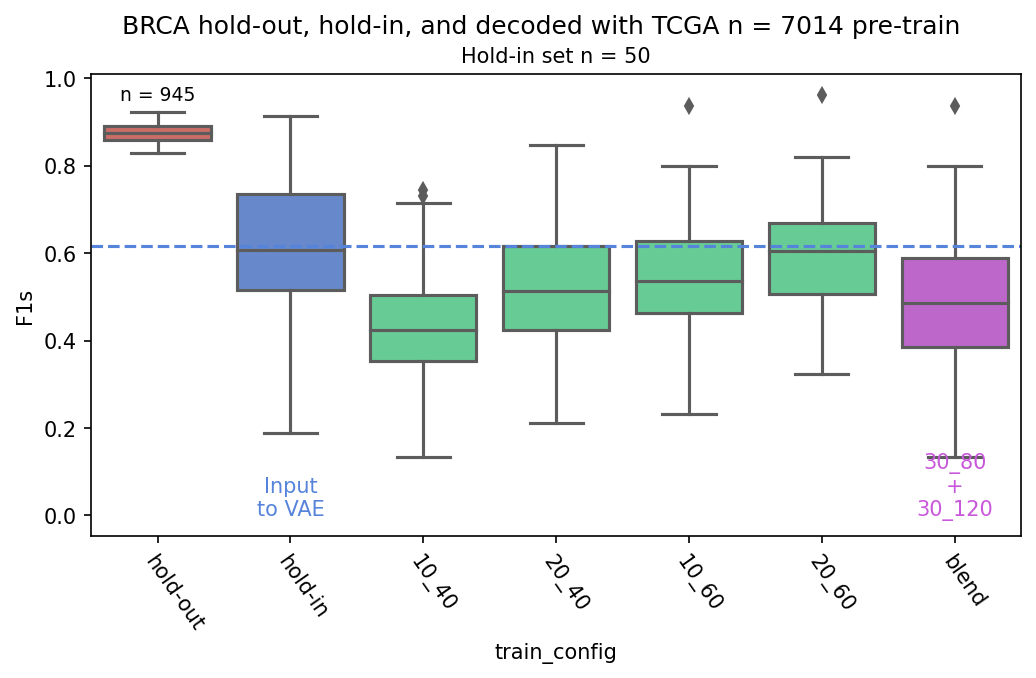

In [32]:
v_scale = 0 # .34

my_pal = {'hold-out': sns.color_palette("hls", 10)[0],
          'hold-in': sns.color_palette("hls", 10)[6],
          '10_40': sns.color_palette("hls", 10)[4],
          '20_40': sns.color_palette("hls", 10)[4],
          '10_60': sns.color_palette("hls", 10)[4],
          '20_60': sns.color_palette("hls", 10)[4],
          'blend': sns.color_palette("hls", 10)[8]}

figure(figsize=(8, 4), dpi=150)
ax = sns.boxplot(tune_stack, x='train_config', y='F1s',
           palette = my_pal)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
rcParams['xtick.major.pad']='.01'
# ax2 = ax.twinx()
plt.plot(.5, v_scale, color = 'white')
plt.plot([-.5,6.5], [hld_in_frame.F1s.mean(),
                 hld_in_frame.F1s.mean()], linestyle='dashed',
        color = sns.color_palette("hls", 10)[6])

plt.suptitle(fine_tune_file.index.name+' hold-out, hold-in, and decoded with TCGA n = '+str(len(pre_train_file))+' pre-train')
plt.title('Hold-in set n = '+str(len(hold_in)),
         fontsize = 10)
plt.annotate('Input\nto VAE', (1,v_scale),
             # fontsize = 15,
             ha = 'center',
            color = sns.color_palette("hls", 10)[6])          # blue
plt.annotate('30_80\n+\n30_120', (6,v_scale),
             # fontsize = 15,
             ha = 'center',
            color = sns.color_palette("hls", 10)[8])          # blue
plt.annotate('n = '+str(len(hold_out)), (0, .95), fontsize = 9, ha = 'center') 
plt.savefig('i_o/'+itr+'/quality_encode/BRCA.fine_TCGA.pre_'+run+'.png', dpi = 150, # < 
           bbox_inches = 'tight')

##### Quality of embedding plot template

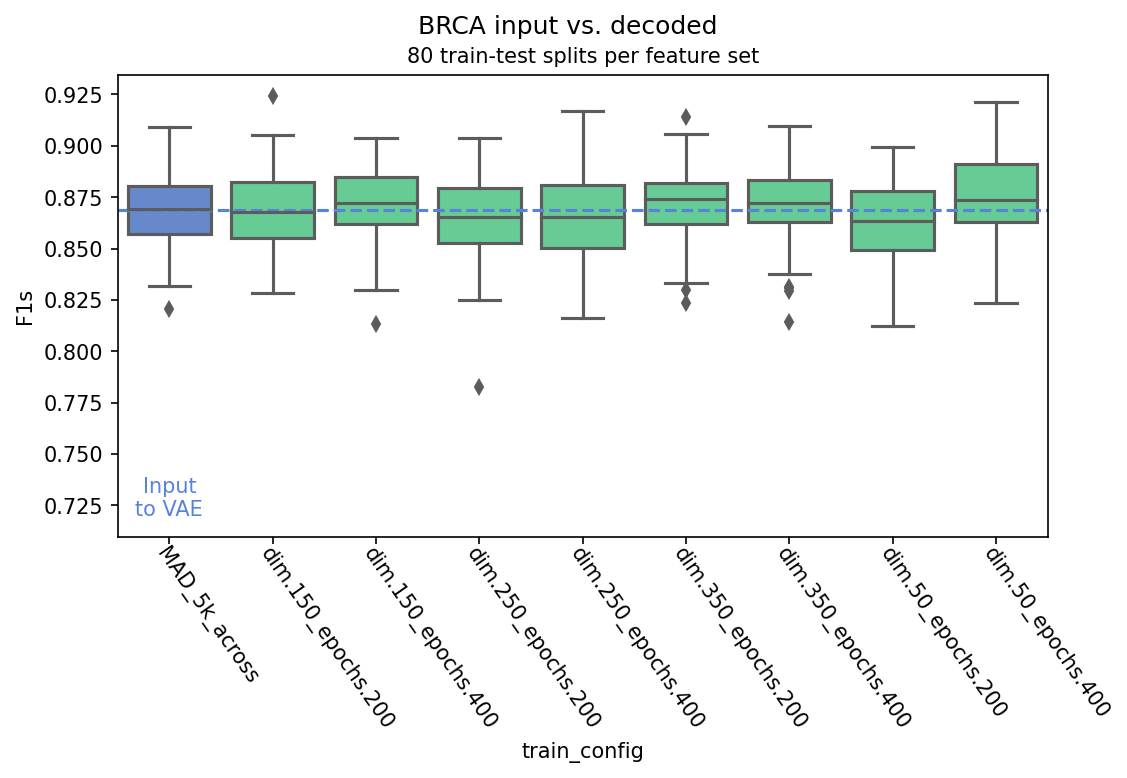

In [155]:
v_scale = .72
low_dim = '50'
high_dim = '350'
my_pal = {'MAD_5k_across': sns.color_palette("hls", 10)[6],
          'dim.150_epochs.200': sns.color_palette("hls", 10)[4],
          'dim.150_epochs.400': sns.color_palette("hls", 10)[4],
          'dim.250_epochs.200': sns.color_palette("hls", 10)[4],
          'dim.250_epochs.400': sns.color_palette("hls", 10)[4],
          'dim.350_epochs.200': sns.color_palette("hls", 10)[4],
          'dim.350_epochs.400': sns.color_palette("hls", 10)[4],
          'dim.50_epochs.200': sns.color_palette("hls", 10)[4],
          'dim.50_epochs.400': sns.color_palette("hls", 10)[4]}
figure(figsize=(8, 4), dpi=150)
ax = sns.boxplot(full_stack, x='train_config', y='F1s',
           palette = my_pal)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
rcParams['xtick.major.pad']='.01'
# ax2 = ax.twinx()
plt.plot(.5, v_scale, color = 'white')
plt.plot([-.5,8.5], [inpt_frame.F1s.mean(),
                 inpt_frame.F1s.mean()], linestyle='dashed',
        color = sns.color_palette("hls", 10)[6])

plt.suptitle(file.index.name+' input vs. decoded')
plt.title(str(trn_tst_splts)+' train-test splits per feature set',
         fontsize = 10)
plt.annotate('Input\nto VAE', (-.0,v_scale),
             # fontsize = 15,
             ha = 'center',
            color = sns.color_palette("hls", 10)[6])          # blue
plt.annotate('Decoded', (.2,.1), fontsize = 15) 
plt.savefig('i_o/box_curve/inpt_dec_figures/BRCA_dim.'+low_dim+'-'+high_dim+'.png', dpi = 150, # < 
           bbox_inches = 'tight')

In [ ]:
sub_samp_drug_sub[~sub_samp_drug_sub.Cell_line.isin(X.Cell_line)].Cell_line

### Quality of encoding plot

## Box curve object examples

In [49]:
hld_in_bx_crv.shape

(1000, 3)

In [50]:
hld_in_bx_crv.head(1)

,data_phase,step_size,F1_score
0,hold-in,10,0.1


## Learning curve devel

In [ ]:
# Learning curve - TEMPLATE
dec_RF_F1_frame = pd.DataFrame()

for smp_sz in list(range(10, 151, 10)): # BRCA <--- across run, mirror input steps above
    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
           
    
    step_frame['data_phase'] = ['decoded'] * resmpl_count
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['F1_score'] = RF_output
    dec_RF_F1_frame = pd.concat( [dec_RF_F1_frame, step_frame] , axis = 0)    
    
print('decoded box curve frame done')

#### Synth devel

In [227]:
new_vals = []
for val in rand_lat_feat_vals:
    # print(val)
    new_vals.append(val+rand_lat_feat_vals.mean()*.05*sample(up_or_down,1)[0])
    # break
    
fuzzed = pd.Series(new_vals, index = synth_index)

<AxesSubplot: >

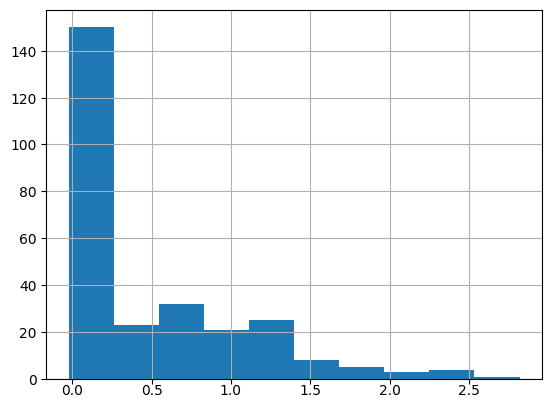

In [228]:
fuzzed.hist()

In [220]:
rand_lat_feat_vals.mean()

0.46026550940441174

In [221]:
type(rand_lat_feat_vals)

pandas.core.series.Series

In [216]:
rand_lat_feat_vals

BRCA
TCGA-BH-A0BA    1.381983
TCGA-A7-A3RF    0.000000
TCGA-PL-A8LX    0.000000
TCGA-A8-A07J    0.669237
TCGA-A8-A06U    1.334681
                  ...   
TCGA-GM-A3NW    0.087688
TCGA-E2-A1IL    0.766139
TCGA-AC-A3EH    0.000000
TCGA-EW-A2FS    0.000000
TCGA-EW-A1P3    0.000000
Name: 0, Length: 272, dtype: float64

In [198]:
up_or_down = [1, -1]

In [213]:
sign = sample(up_or_down,1)[0]
sign

-1

In [205]:
lat_col.mean()

0.5087377233602941

<AxesSubplot: >

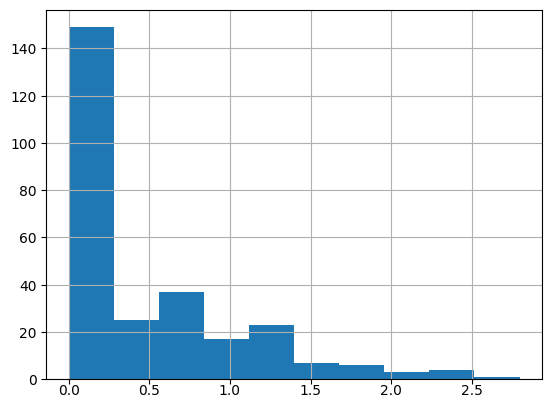

In [217]:
rand_lat_feat_vals.hist()

<AxesSubplot: >

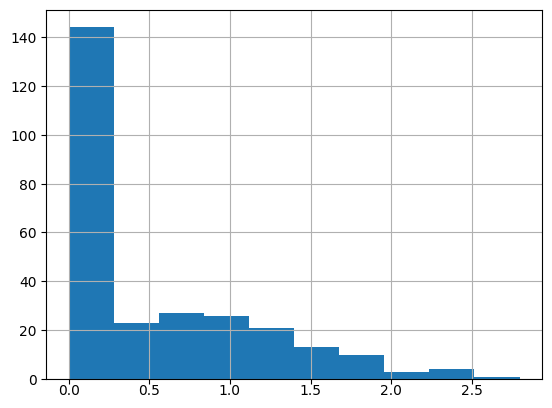

In [206]:
lat_col.hist()

In [145]:
synth_full_frame.shape  # hold in samples vs. 100 dim latent space

(40, 101)

In [ ]:
# 2022-12-19, 4.92 Gigs

In [85]:
# Trained decoder still in memory (usually about 5GB at this point)
synth_decoded = pd.DataFrame(decoder.predict( # note:
    synth_full_frame.iloc[:, 1:]),
        index=synth_full_frame.index, # Putting on synthetic index
            columns=hold_in.iloc[:, 1:].columns) # Putting on og columns

In [86]:
synth_decoded_labeled = pd.concat(
    [pd.DataFrame(synth_full_frame.Labels),
     synth_decoded] , axis =1)

In [87]:
df_to_clf = synth_decoded_labeled

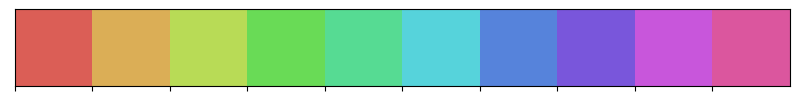

In [92]:
sns.palplot(sns.color_palette("hls", 10))

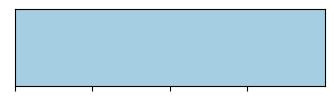

In [96]:
sns.palplot(plt.cm.Paired(0))

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


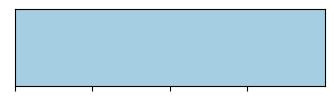

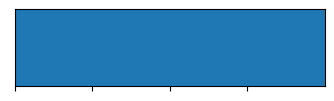

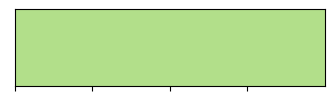

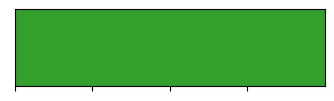

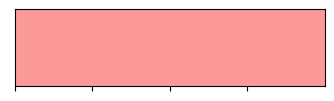

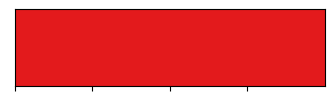

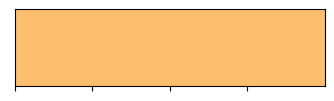

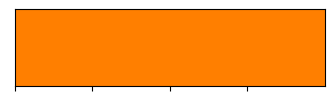

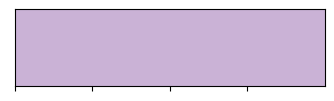

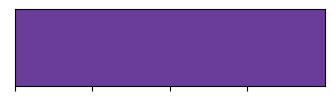

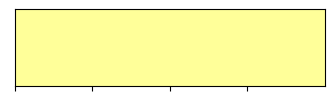

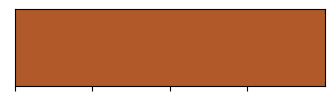

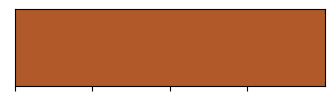

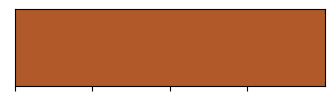

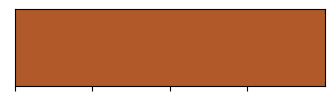

In [100]:
for i in list(range(0,15)):
    print(sns.palplot(plt.cm.Paired(i)))

Start input transfer
Ten cross-folds complete
Input vs decoded synthetic transfer predictions complete


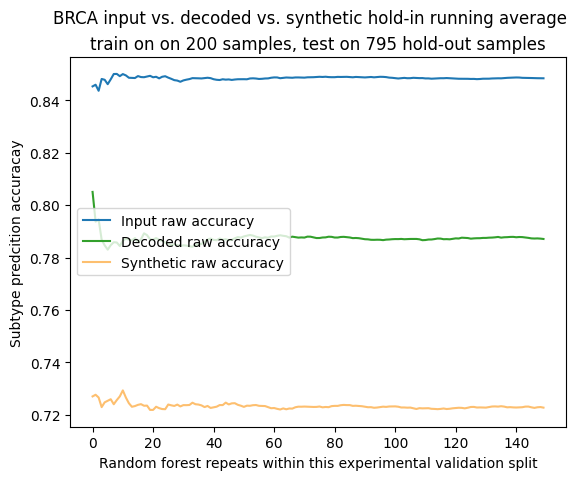

In [106]:
# Orange triple running average
print('Start input transfer')

raw_acc_lst = []
synth_running_average_acrcy = []
for r in list(range(0, repeats)): # pre-set
    if r == 10:
        print('Ten cross-folds complete')
    X_synth = synth_decoded_labeled.iloc[:, 1:] #         <----------- Train on hold-in
    y_synth = synth_decoded_labeled.iloc[:, 0]
    
    clf = RandomForestClassifier() # <--- reset classifier each time through loop
    clf.fit(X_synth, y_synth)
        # Done with training on the SYNTHETIC
    # Now get X_test_hold_out and y_test_hold_out, same as everything
    
    X_hold_out = hold_out.iloc[:, 1:] # <----- Test on hold-out
    y_hold_out = hold_out.iloc[:, 0]
    
    raw_acc = accuracy_score(y_hold_out, clf.predict(X_hold_out))

    raw_acc_lst.append(raw_acc)
    
    synth_running_average_acrcy.append(mean(raw_acc_lst))

print('Input vs decoded synthetic transfer predictions complete')

plt.plot(inpt_running_average_acrcy, color = plt.cm.Paired(1), label = 'Input raw accuracy')
plt.plot(dec_running_average_acrcy, color = plt.cm.Paired(3), label = 'Decoded raw accuracy')
plt.plot(synth_running_average_acrcy, color = plt.cm.Paired(6), label = 'Synthetic raw accuracy')
plt.title('train on on '+str(len(hold_in))+' samples,'+
          ' test on '+str(len(hold_out))+' hold-out samples')
plt.suptitle(hold_in.index.name+' input vs. decoded vs. synthetic hold-in running average')

plt.ylabel('Subtype predcition accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/val_1.1/direct_train_input_vs_decoded_vs_synthetic_running_average_'+run+'.png', bbox_inches = 'tight')

In [ ]:
# Original, v 1.1 checkpoint to put in first triple learning curve

In [84]:
# 05 an 10 percent fuzz toggle
synth_decoded = pd.DataFrame(decoder.predict(
    synth_full_frame05.iloc[:, 1:]),
        index=synth_full_frame.index,
            columns=hold_in.iloc[:, 1:].columns)
synth_decoded_labeled = pd.concat(
    [pd.DataFrame(synth_full_frame.Labels),
     synth_decoded] , axis =1)
df_to_clf = synth_decoded_labeled

NameError: name 'synth_full_frame05' is not defined

##### Synth F1

In [44]:
smp_sz

110

In [45]:
synth_full_frame

,Labels,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SYNTH-BRCA-00000,BRCA_1,0.225564,0.281646,0.001935,0.015813,0.526976,0.464221,0.223615,0.552765,0.049718,...,0.815883,0.006519,0.089208,0.000777,0.220017,0.299029,0.518156,0.203315,1.094813,0.006644
SYNTH-BRCA-00001,BRCA_1,0.655348,0.629770,-0.001935,-0.015813,0.015845,-0.013738,0.108580,1.090222,0.048283,...,-0.006970,0.606905,1.691756,-0.000777,0.009497,0.557246,0.672525,0.281862,1.008585,0.302886
SYNTH-BRCA-00002,BRCA_1,0.511011,0.013248,-0.001935,0.408692,0.526976,-0.013738,0.243240,-0.017390,0.021439,...,0.503820,0.006519,1.213610,0.000777,0.249765,0.439101,0.581948,0.384356,1.075425,0.006644
SYNTH-BRCA-00003,BRCA_1,-0.018059,-0.013248,0.079866,0.539213,0.015845,0.212720,-0.016301,-0.017390,0.000718,...,0.006970,0.006519,0.029571,0.000777,0.054575,0.415167,0.651964,0.349432,1.008585,0.006644
SYNTH-BRCA-00004,BRCA_1,0.352220,0.080307,0.001935,0.015813,0.025306,0.338349,0.691053,0.701724,-0.000718,...,-0.006970,0.006519,0.940270,-0.000777,0.245093,0.775409,0.847134,0.349432,1.012287,0.206116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SYNTH-BRCA-00095,BRCA_4,0.351293,-0.004015,0.000000,0.487052,0.081199,0.000000,0.000977,-0.008644,-0.003794,...,-0.022604,0.000000,-0.028812,0.000774,0.000000,0.479959,0.004937,0.004988,0.424940,0.001202
SYNTH-BRCA-00096,BRCA_4,0.009077,0.004015,0.000000,0.557110,0.396230,0.000000,0.000977,0.496101,0.003794,...,0.022604,0.000000,0.568415,-0.000774,0.000000,0.003404,-0.004937,0.004988,0.588658,0.001202
SYNTH-BRCA-00097,BRCA_4,0.494406,0.088355,0.000000,0.563738,-0.005810,0.000000,0.000977,0.461735,0.074674,...,0.600985,0.000000,0.028812,-0.000774,0.000000,0.003404,0.004937,0.552103,0.009309,-0.001202
SYNTH-BRCA-00098,BRCA_4,0.009077,-0.004015,0.000000,-0.020087,0.005810,0.000000,-0.000977,0.513390,0.125885,...,0.338027,0.000000,0.996478,-0.000774,0.000000,0.473151,0.004937,-0.004988,0.009309,-0.001202


In [50]:
# Two degrees of noise - fail

# synth_05 = pd.DataFrame()
# synth_10 = pd.DataFrame()
synth = pd.DataFrame()

for smp_sz in list(range(10, 151, 10)): # BRCA <--- across run, mirror input steps above
    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
        # break
    # break
    # synth_RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    step_frame['data_phase'] = ['synth'] * resmpl_count
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['F1_score'] = RF_output
    synth = pd.concat( [synth, step_frame] , axis = 0)
print('synth bx_crv done')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
synth bx_crv done


In [87]:
synth

,data_phase,step_size,F1_score
0,synth,10,0.333333
1,synth,10,0.250000
2,synth,10,0.000000
3,synth,10,0.666667
4,synth,10,0.500000
...,...,...,...
55,synth,150,0.742879
56,synth,150,0.645469
57,synth,150,0.611775
58,synth,150,0.631111


In [51]:
box_curve_frame = pd.concat(
    [hld_out_bx_crv,
     hld_in_bx_crv,
     dec_RF_F1_frame,
     synth] , axis = 0)

### Box crv main

In [52]:
run

'r02'

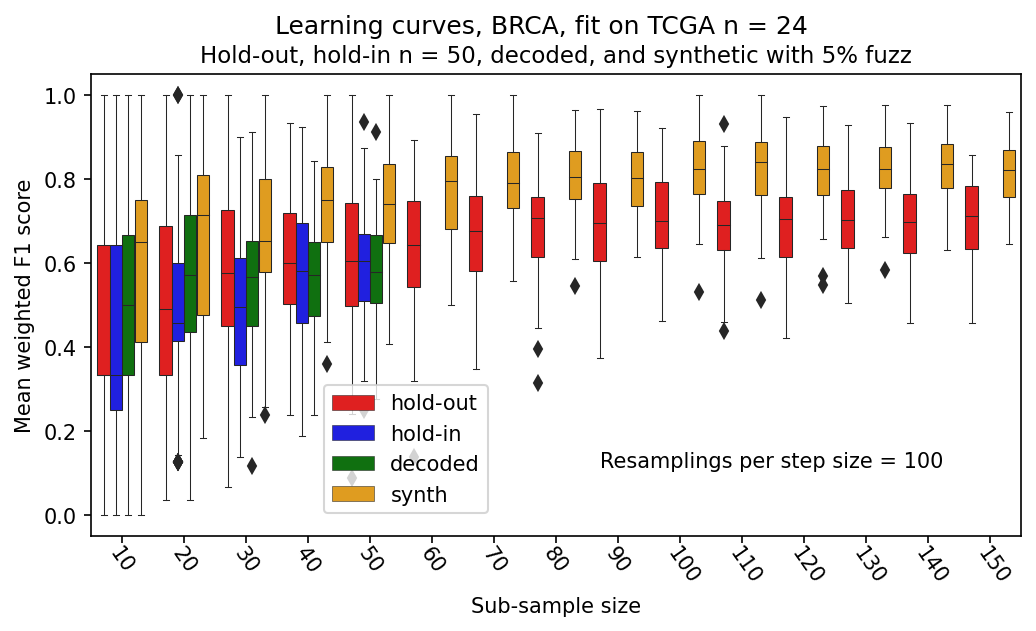

In [54]:
# Box curve - using hue function on data phase and step size
# Use a dataframe with input, decoded, and synthetic samples
figure(figsize=(8, 4), dpi=150)
ax = sns.boxplot(x='step_size', y='F1_score',
            hue='data_phase', palette=['red','blue', 'green', 'orange'],
            data=box_curve_frame, linewidth = .5)

# plt.plot(list(dec_RF_F1_means.keys()),
#        dec_RF_F1_means.values(),label='decoded', color = 'green')


plt.suptitle('Learning curves, '+fine_tune_file.index.name+', fit on TCGA n = 24')
# plt.title('VAE input data: MAD 5K GEXP')
plt.title('Hold-out, hold-in n = '+str(len(hold_in))+', decoded, and synthetic with 5% fuzz', fontsize = 11) # across or within cohorts
plt.ylabel('Mean weighted F1 score')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .3), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc=(.25,.05))
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
plt.savefig(
    'i_o/bx_crv4/lrn_crv/tcga_brca_bx_crv4_'+run+'.png', bbox_inches = 'tight')

##### Learning curve template

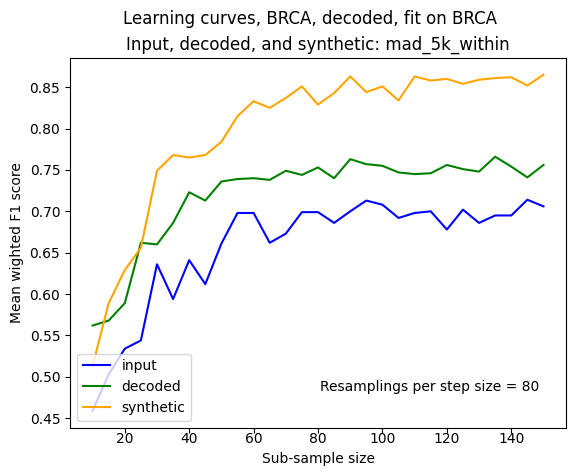

In [330]:
# Superimpose input, decoded, and synthetic, template for box curve
    # Using two dicts:
        # inpt_RF_F1_means
        # dec_RF_F1_means

plt.plot(list(inpt_RF_F1_means.keys()),
       inpt_RF_F1_means.values(),label='input', color = 'blue')
plt.plot(list(dec_RF_F1_means.keys()),
       dec_RF_F1_means.values(),label='decoded', color = 'green')
plt.plot(list(synth_RF_F1_means.keys()),
       synth_RF_F1_means.values(),label='synthetic', color = 'orange')

plt.suptitle('Learning curves, '+df_to_clf.index.name+', decoded, fit on '+
             df_to_clf.index.name)
# plt.title('VAE input data: MAD 5K GEXP')
plt.title('Input, decoded, and synthetic: ' + feature_set) # across or within cohorts
plt.ylabel('Mean wighted F1 score')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .2), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc="lower left")
plt.savefig(
    'i_o/box_whisk/'+
    str(df_to_clf.index.name)+'.inpt_and_dec_fit_on.'+fit_on +'_'+feature_set+'_'+
    str(list(inpt_RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+
    '_'+'rsmpls.'+str(resmpl_count)+
    '_super_1_synth.png', bbox_inches = 'tight')

### Made-up data

### Hold out - Input, Decoded, and Synth

In [ ]:
hold out - done
decoded hold out - need to use trained encoder, decoder
synthetic from decoded hold out

print hold out size
print hold in size

#### Hold out Input F1 object

In [332]:
df_to_rf = hold_out

In [333]:
print('Starting Hold out input learning curve object generation')

hld_ot_inpt_RF_F1_means = {}
for smp_sz in list(range(10, 151, 5)): # BRCA <--- across run, plot up to 100?
    
    print(smp_sz)
    
    RF_output = []
    resmpl_count = 80 # 250
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_rf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)

    hld_ot_inpt_RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    
    # INPUT dict - raw F1 scores for error plot <note>
    # inpt_RF_F1_dct[smp_sz] = RF_output
    # break
print('Hold-out input Learning curve object generated, send to plot function')

Starting Hold out input learning curve object generation
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
Hold-out input Learning curve object generated, send to plot function


#### Hold out Decoded F1 object

In [334]:
feature_set = 'mad_5k_within'
decode_df = hold_out
c = file.index.name
fit_on = c
super_v = '_hold-out'

In [335]:
itr

'box_whisk'

In [336]:
# No loss plot, here, not training

y_df = decode_df.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(decode_df.iloc[:, 1:])),
                       index=decode_df.index, columns=decode_df.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(decode_df.iloc[:, 1:]),
             index=decode_df.index,
                # columns=decode_df.iloc[:, 1:].columns # Columns are different because this is latent space
        )
latent_object.index.name = c
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv('i_o/'+itr+'/'+c+'_fit_on.'+fit_on+
                     '_latent_object_latent_dim.'+str(latent_dim)+
    '_epochs.'+str(epochs)+'_'+feature_set+super_v+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+itr+'/'+c+'_fit_on.'+fit_on+'_decoded_latent_dim.'+
    str(latent_dim)+
    '_epochs.'+str(epochs)+'_'+feature_set+super_v+
    '.tsv',
    sep = '\t')

In [337]:
df_to_clf = pd.read_csv(
    'i_o/box_whisk/BRCA_fit_on.BRCA_decoded_latent_dim.120_epochs.80_mad_5k_within_hold-out.tsv',
    sep = '\t', index_col = 0)

In [338]:
# Superimpose dictionary 2 (decoded) samples build, version super 0, now in figure_five

hld_ot_dec_RF_F1_means = {}
for smp_sz in list(range(10, 151, 5)): # BRCA <--- across run, mirror input steps above
    
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
           
    hld_ot_dec_RF_F1_means[smp_sz] = round(mean(RF_output), 3)

print('Second learning curve dictionary for superimpose plot done')

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
Second learning curve dictionary for superimpose plot done


#### Synthetic from Decoded Hold out F1 object

In [339]:
chrt = 'BRCA'
latent_obj = pd.read_csv(
    'i_o/box_whisk/BRCA_fit_on.BRCA_latent_object_latent_dim.120_epochs.80_mad_5k_within_hold-out.tsv',
        sep = '\t', index_col = 0)

In [340]:
synth_ndx_strt = 0

synth_full_frame = pd.DataFrame()

for subtype in sorted(latent_obj.Labels.unique()):
    print(subtype)
    
    sub = latent_obj[latent_obj.Labels == subtype]
    synth_lat_feat_vec = []
    
    sub_len = len(sub)
    synth_sub_len = len(sub)*2
    
    synth_index = ['SYNTH-' + chrt + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])

    for lat_feat in sub.columns[1:]:

        lat_col = sub.loc[:, lat_feat]
        
        rand_lat_feat_vals = lat_col.sample(

            synth_sub_len, replace = True,

        )
        rand_lat_feat_vals.index = synth_index
        synth_sub_frame = pd.concat(
            [synth_sub_frame, rand_lat_feat_vals], axis = 1)

    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0)
    synth_ndx_strt = synth_ndx_strt + synth_sub_len

BRCA_1
BRCA_2
BRCA_3
BRCA_4


In [341]:
synth_full_frame

,Labels,0,1,2,3,4,5,6,7,8,...,110,111,112,113,114,115,116,117,118,119
SYNTH-BRCA-00000,BRCA_1,0.305943,0.000000,1.012343,1.511696,1.927185,0.000000,1.368401,0.000000,0.000000,...,1.069443,0.193796,0.347717,0.000000,0.000000,0.312956,0.642466,0.475284,0.819861,0.555516
SYNTH-BRCA-00001,BRCA_1,0.000000,0.618625,0.431357,0.623724,0.000000,0.000000,0.291508,0.000000,0.000000,...,1.293553,0.000000,0.000000,0.000000,0.000000,0.589808,0.848942,1.477199,0.137750,0.594626
SYNTH-BRCA-00002,BRCA_1,0.000000,1.963241,0.000000,0.810918,0.000000,0.000000,0.000000,0.030998,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.971468,0.154200,0.957616,0.731654,0.195305,1.340720
SYNTH-BRCA-00003,BRCA_1,0.794886,0.286624,1.639823,1.502412,0.472589,0.000000,0.000000,0.402419,0.000000,...,0.000000,1.271559,0.000000,0.000000,0.000000,0.671997,2.120403,0.149687,0.344697,0.000000
SYNTH-BRCA-00004,BRCA_1,0.890828,1.963241,1.533001,1.281164,0.323941,2.469091,0.478906,0.000000,0.000000,...,0.684412,1.413718,0.000000,0.000000,1.286682,0.022155,0.000000,0.032499,0.000000,2.125566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SYNTH-BRCA-00995,BRCA_4,0.000000,0.857365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.794510,...,0.000000,0.471138,0.000000,0.846612,1.332895,0.000000,0.815193,0.000000,0.000000,0.298652
SYNTH-BRCA-00996,BRCA_4,0.000000,1.194510,0.000000,0.000000,0.000000,0.571467,0.473491,0.965749,1.390114,...,0.499132,0.676084,0.561972,0.429470,0.000000,0.000000,0.000000,0.000000,1.337866,0.685839
SYNTH-BRCA-00997,BRCA_4,0.000000,0.000000,0.000000,0.000000,0.000000,1.416160,0.308208,0.000000,3.432365,...,0.018207,0.000000,0.000000,0.154154,0.000000,0.000000,0.641849,0.267730,1.838134,0.000000
SYNTH-BRCA-00998,BRCA_4,0.000000,0.975253,0.000000,0.000000,0.000000,1.808364,0.124006,0.004676,2.521417,...,1.110237,0.000000,0.000000,0.000000,0.000000,0.000000,0.877178,0.000000,0.083407,2.452142


In [342]:
synth_decoded = pd.DataFrame(decoder.predict(
    synth_full_frame.iloc[:, 1:]),
        index=synth_full_frame.index,
            columns=decode_df.iloc[:, 1:].columns)
synth_decoded_labeled = pd.concat(
    [pd.DataFrame(synth_full_frame.Labels),
     synth_decoded] , axis =1)
df_to_clf = synth_decoded_labeled

In [343]:
# Hold out synthetic, object 6 for Hold-out plot

hld_ot_synth_RF_F1_means = {}
    
for smp_sz in list(range(10, 151, 5)):
    print(smp_sz)
    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
           
    hld_ot_synth_RF_F1_means[smp_sz] = round(mean(RF_output), 3)

print('BRCA hold out dict 3 done')

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
BRCA hold out dict 3 done


In [345]:
df_to_clf.index.name = 'BRCA'

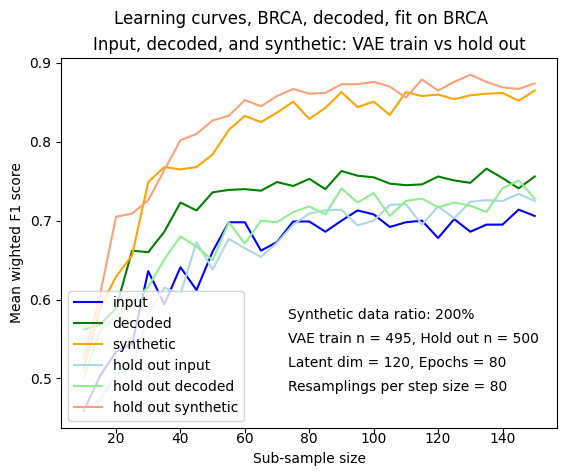

In [350]:
plt.plot(list(inpt_RF_F1_means.keys()),
       inpt_RF_F1_means.values(),label='input', color = 'blue')
plt.plot(list(dec_RF_F1_means.keys()),
       dec_RF_F1_means.values(),label='decoded', color = 'green')
plt.plot(list(synth_RF_F1_means.keys()),
       synth_RF_F1_means.values(),label='synthetic', color = 'orange')

plt.plot(list(hld_ot_inpt_RF_F1_means.keys()),
       hld_ot_inpt_RF_F1_means.values(),label='hold out input', color = 'lightblue')
plt.plot(list(hld_ot_dec_RF_F1_means.keys()),
       hld_ot_dec_RF_F1_means.values(),label='hold out decoded', color = 'lightgreen')
plt.plot(list(hld_ot_synth_RF_F1_means.keys()),
       hld_ot_synth_RF_F1_means.values(),label='hold out synthetic', color = 'lightsalmon')

plt.suptitle('Learning curves, '+df_to_clf.index.name+', decoded, fit on '+
             df_to_clf.index.name)
# plt.title('VAE input data: MAD 5K GEXP')
plt.title('Input, decoded, and synthetic: VAE train vs hold out') # across or within cohorts
plt.ylabel('Mean wighted F1 score')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.45, .2), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )

plt.annotate('VAE train n = 495, Hold out n = 500',
                xy=(.45, .3), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )

plt.annotate('Latent dim = 120, Epochs = 80',
                xy=(.45, .25), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )

plt.annotate('Synthetic data ratio: 200%',
                xy=(.45, .35), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )

plt.legend(loc="lower left")
plt.savefig(
    'i_o/box_whisk/'+
    str(df_to_clf.index.name)+'.inpt_and_dec_fit_on.'+fit_on +'_'+feature_set+'_'+
    str(list(inpt_RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+
    '_'+'rsmpls.'+str(resmpl_count)+
    '_super_1_synth_hold_out.png', bbox_inches = 'tight')

### Box curve archive

In [ ]:
# Input template

print('starting learning curve generation on labled feature set')
# inpt_RF_F1_dct = {}

inpt_RF_F1_means = {}
# for smp_sz in list(range(10, 70, 5)): # UVM <--- across run, plot up to 100?
for smp_sz in list(range(10, 151, 5)): # BRCA <--- across run, plot up to 100?
# for smp_sz in list(range(15, 76, 5)): # ACC <---
    
    print(smp_sz)
    
    RF_output = []
    resmpl_count = 80 # 250
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_rf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)

    inpt_RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    
    # INPUT dict - raw F1 scores for error plot <note>
    # inpt_RF_F1_dct[smp_sz] = RF_output
    # break
print('Learning curve object generated, send to plot function')

In [ ]:
# Superimpose dictionary 2 (decoded) samples build, version super 0, now in figure_five

dec_RF_F1_means = {}
dec_RF_F1_dct = {}

for smp_sz in list(range(10, 41, 5)): # BRCA <--- across run, mirror input steps above
    
    print(smp_sz)

    RF_output = []
    # resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
           
    dec_RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    dec_RF_F1_dct[smp_sz] = RF_output
print('Second learning curve dictionary for superimpose plot done')

In [ ]:
# Synthetic sample generator template

synth_ndx_strt = 0

synth_full_frame = pd.DataFrame() # Storage object

# Take the reset starting index position from end of loop to create next synthetic subtype set

for subtype in sorted(latent_obj.Labels.unique()): # Subset the latent feature frame on each subtype
    
    print(subtype)
    
    # break
    
    sub = latent_obj[latent_obj.Labels == subtype]
    synth_lat_feat_vec = []
    
    sub_len = len(sub)
    synth_sub_len = len(sub)*1
    
    synth_index = ['SYNTH-' + chrt + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    # break
    
    synth_sub_frame = pd.DataFrame(index = synth_index) # create synthetic subframe
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    # break
    for lat_feat in sub.columns[1:]:               # Go through the subtype latent feature set,
        # print(lat_feat)                            # skipping the Labels column
        lat_col = sub.loc[:, lat_feat]
        
        rand_lat_feat_vals = lat_col.sample(
            # len(sub), replace = True, # <note> can toggle replacement off if taking less than number samples
            synth_sub_len, replace = True,
            # index = synth_index
        ) # *
        rand_lat_feat_vals.index = synth_index
        synth_sub_frame = pd.concat(
            [synth_sub_frame, rand_lat_feat_vals], axis = 1)
        # break
    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0)
    # break
    
    # synth_ndx_strt = synth_ndx_strt + len(sub)
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
    
    # break

In [ ]:
# Synthtic learing curve template for box curve, above

# dec_RF_F1_means = {}
synth_RF_F1_means = {}
# for smp_sz in list(range(10, 70, 5)): # UVM <--- figure_five, run 1
# for smp_sz in list(range(10, 145, 5)): # UVM <--- figure_five, run 2, this dict will be a different length! 
    
for smp_sz in list(range(10, 151, 5)): # BRCA <--- across run, mirror input steps above
    
    print(smp_sz)

    RF_output = []
    # resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
           
    synth_RF_F1_means[smp_sz] = round(mean(RF_output), 3)

print('BRCA dict 3 done')